# Cambio 3.1

## Cambio 3 equations of motion
The equations of motion for Cambio3 are as follows:

$$
F_{land->atm} =  k_{la} \ \ \ (1) 
$$

$$
F_{atm->land} = k_{al0} +  k_{al1} \times \sigma_{floor}(T_{anomaly}) \times [C_{atm}] \ \ \ (2)
$$

$$
F_{ocean->atm} = k_{oa} [C_{ocean}] \ \ \ (3)
$$

$$
F_{atm->ocean} = k_{ao} [C_{atm}] \ \ \ (4)
$$

$$
F_{human->atm} = \epsilon(t) \ \ \ (5)
$$


### Significant differences between Cambio2 and Cambio3

One difference is that Cambio3 makes use of a new function that creates scheduledflows "on the fly" (instead of picking up a pre-existing file). This is the function CL.MakeEmissionsScenarioLTE.

Another difference is that Cambio3 includes feedbacks as well as diagnostics. One of these is shown explicitly in Eq. (2) above, where we calculate the flux of carbon from the atmosphere to the land. In Cambio2, this was just $k_{al0} +  k_{al1} \times [C_{atm}]$, meaning that a bigger $k_{al1}$ resulted in a bigger value of the atmosphere-to-land carbon flux. That's called the $CO_2$ fertilization effect -- basically, because plants photosynthesize better when there's more $CO_2$ in the air. But it's also known that $CO_2$ fertilization suffers diminishing returns in a warmer climate. That's where the factor $\sigma_{floor}(T_{anomaly})$ comes in: if the temperature anomaly rises above some threshold value (specified here by 'F_al_transitionT', in the ClimateParams dictionary), then $\sigma_{floor}(T_{anomaly})$ drops to some new value, less than $1$, which in turn means that $F_{atm->land}$ goes up a little more slowly in response to higher $CO_2$ levels in the atmosphere.

### How you're going to use Cambio3.1
Once you've gone through the activites prompted below, the idea is that you'll:
1. Take snapshots of one some of the results (graphs). You can do that with a screen-capture, or with the disk icon that appears below the plot.
1. After modifying flags in PropagateClimateState (they start with "I_want ...") to activate a given feedback, impact, or constraint of interest, or modifying parameters in the ClimateParams dictionary, you'll run the entire notebook again from top to bottom, and take more snapshots for comparison.

### Learning goals
1. I can generate scheduled flows "on the fly," with a specified long term emission value.
1. I can modify the line widths and vertical ranges on plots.
1. I know how to activate various feedbacks, impacts, and constraints, including:
- the impact of temperature on carbon fluxes, and vice versa
- the impact of albedo on temperature, and vice versa
- stochasticity in the model
- constraint on how fast Earth's albedo can change

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5io
import Conn350Lib as CL
from copy import copy as makeacopy

In [2]:
%matplotlib notebook

### The ClimateParams dictionary
The cell below creates a dictionary of climate parameters.

In [3]:
# Start with an empty dictionary
ClimateParams = {}

# Preindustrial climate values
ClimateParams['preindust_C_atm'] = 615
ClimateParams['preindust_C_ocean'] = 350
ClimateParams['preindust_albedo'] = 0.3
ClimateParams['preindust_pH'] = 8.2

# Parameter for the basic sensitivity of the climate to increasing CO2
ClimateParams['climate_sensitivity'] = 3/ClimateParams['preindust_C_atm'] # IPCC: 3 degrees for doubled CO2

# Carbon flux constants
ClimateParams['k_la'] = 120
ClimateParams['k_al0'] = 113
ClimateParams['k_al1'] = 0.0114
ClimateParams['k_oa'] = 0.2
ClimateParams['k_ao'] = 0.114

# Parameter for the ocean degassing flux feedback
ClimateParams['DC'] = 0.034 # Pretty well known from physical chemistry

# Parameters for albedo feedback
ClimateParams['albedo_sensitivity'] = -100 # Based on our radiative balance sensitivity analysis
ClimateParams['albedo_transition_temperature'] = 4 # T at which significant albedo reduction kicks in (a guess)
ClimateParams['albedo_transition_interval'] = 1 # Temperature range over which albedo reduction kicks in (a guess)
ClimateParams['max_albedo_change_rate'] = 0.0006 # Amount albedo can change in a year (based on measurements)
ClimateParams['fractional_albedo_floor'] = 0.9 # Maximum of 10% reduction in albedo (a guess)

# Parameters for the atmosphere->land flux feedback
ClimateParams['F_al_transitionT'] = 4 # T anomaly at which photosynthesis will become impaired (a guess)
ClimateParams['F_al_transitionTinterval'] = 1 # Temperature range over which photosynthesis impairment kicks in (guess)
ClimateParams['fractional_F_al_floor'] = 0.9 # Maximum of 10% reduction in F_al (a guess)

# Parameter for stochastic processes
ClimateParams['Stochastic_C_atm_std_dev'] = 0.1 # Set to zero for no randomness in C_atm

# This displays the dictionary contents
display(ClimateParams)

{'preindust_C_atm': 615,
 'preindust_C_ocean': 350,
 'preindust_albedo': 0.3,
 'preindust_pH': 8.2,
 'climate_sensitivity': 0.004878048780487805,
 'k_la': 120,
 'k_al0': 113,
 'k_al1': 0.0114,
 'k_oa': 0.2,
 'k_ao': 0.114,
 'DC': 0.034,
 'albedo_sensitivity': -100,
 'albedo_transition_temperature': 4,
 'albedo_transition_interval': 1,
 'max_albedo_change_rate': 0.0006,
 'fractional_albedo_floor': 0.9,
 'F_al_transitionT': 4,
 'F_al_transitionTinterval': 1,
 'fractional_F_al_floor': 0.9,
 'Stochastic_C_atm_std_dev': 0.1}

### Introducing the "LTE" emissions scenario maker
Here we introduce a new emissions scenario maker. A few differences with respect to what we have done previously are:

1. This is done "on the fly" -- i.e., it's a function call to "CL.MakeEmissionsScenarioLTE". So there's no need to generate a separate scheduled flows file!
1. LTE stands for "long-term-emissions." That's specified by the last parameter, SF_LTE. In the cell below, we specify 10 GtC as a default, but it can be anything (even negative). If you want to reproduce our original, more or less, you can specify SF_LTE=0.

After generating the scenario, we plot the emissions in GtC/year, and again in GtCO2/year, by dividing by 0.27; the latter is so that we can compare to other models, like EnROADS, which use GtCO2.

peak 15.412922146729734 525


<IPython.core.display.Javascript object>


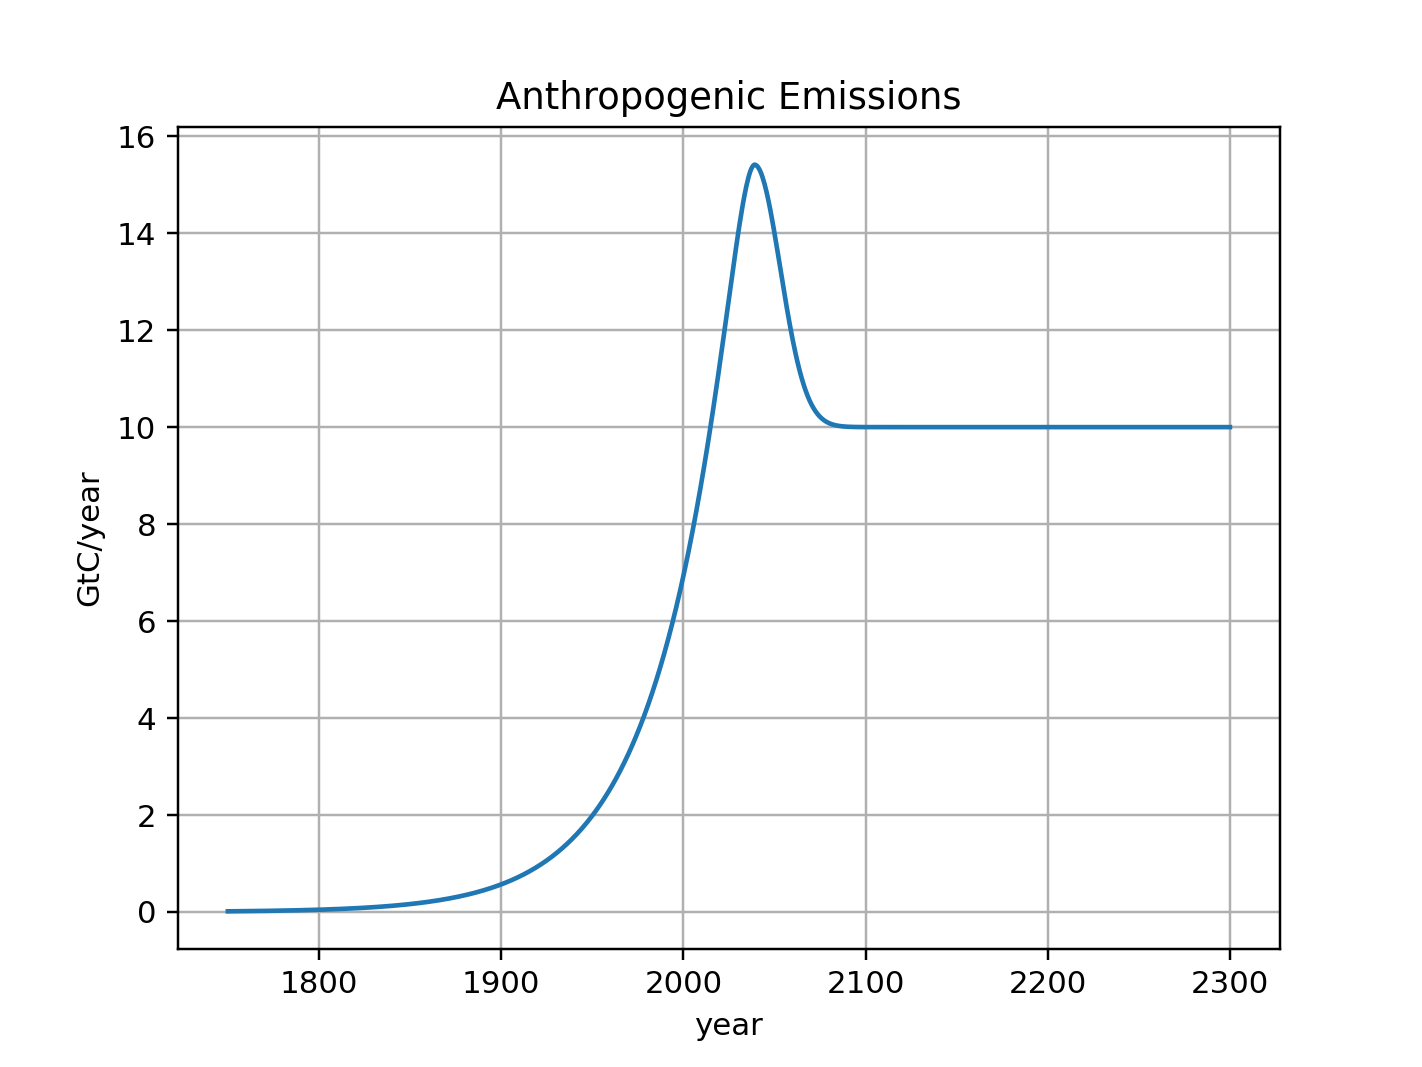

<IPython.core.display.Javascript object>


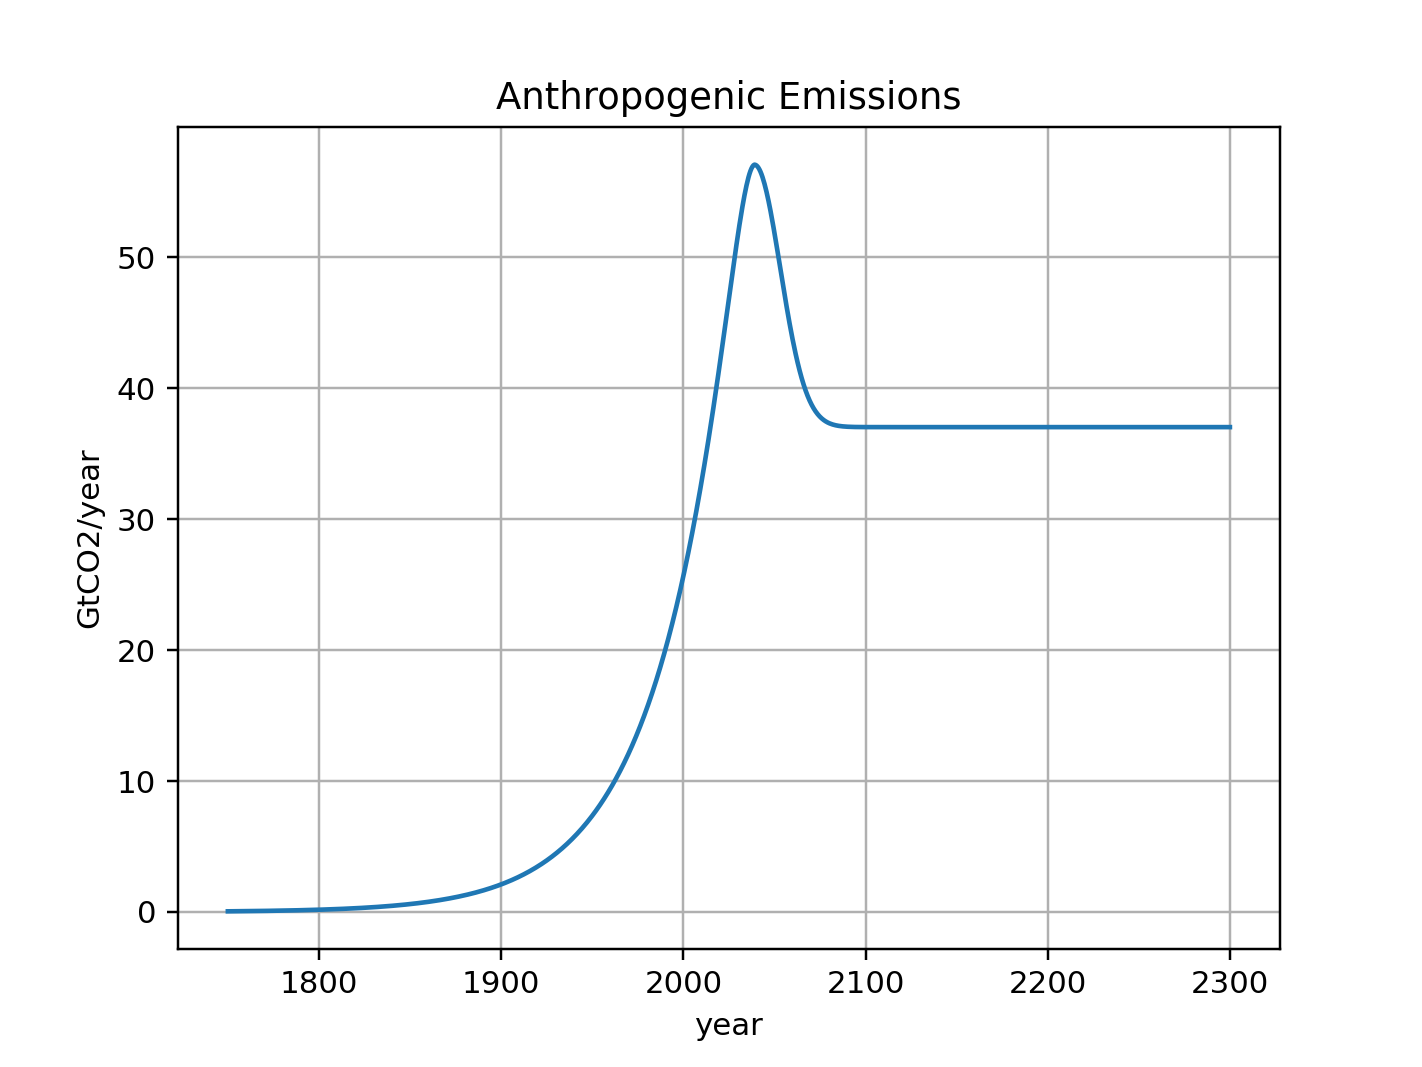

Text(0, 0.5, 'GtCO2/year')

In [14]:
# Parameters of the LTE emissions schedule
SF_t_start = 1750
SF_t_stop = 2300
SF_nsteps = 1000
SF_k = 0.025
SF_t_trans = 2050
SF_delta_t_trans = 20
SF_t_0 = 2020
SF_eps_0 = 11.3
SF_LTE = 10

# Calling the LTE emissions scenario maker
time, eps = CL.MakeEmissionsScenarioLTE(\
    SF_t_start,SF_t_stop,SF_nsteps,SF_k,SF_eps_0,SF_t_0,SF_t_trans,SF_delta_t_trans,SF_LTE)

# Plot it in units GtC/year
plt.figure()
plt.plot(time,eps)
plt.grid(True)
plt.title('Anthropogenic Emissions')
plt.xlabel('year')
plt.ylabel('GtC/year')

# Also plot in GtCO2/year (for easier comparison with EnROADS)
plt.figure()
plt.plot(time,eps/.27)
plt.grid(True)
plt.title('Anthropogenic Emissions')
plt.xlabel('year')
plt.ylabel('GtCO2/year')

### Your turn
Repeat what we did in the cell above, but change parameters to a scenario more to your liking. You might, for example, want a decarbonization transition take place in the year 2040 instead of 2050, or set the long-term emissions to a lower value, or stop in year 2200 rather than 2100 (your choice).

peak 12.463803774023669 620


<IPython.core.display.Javascript object>


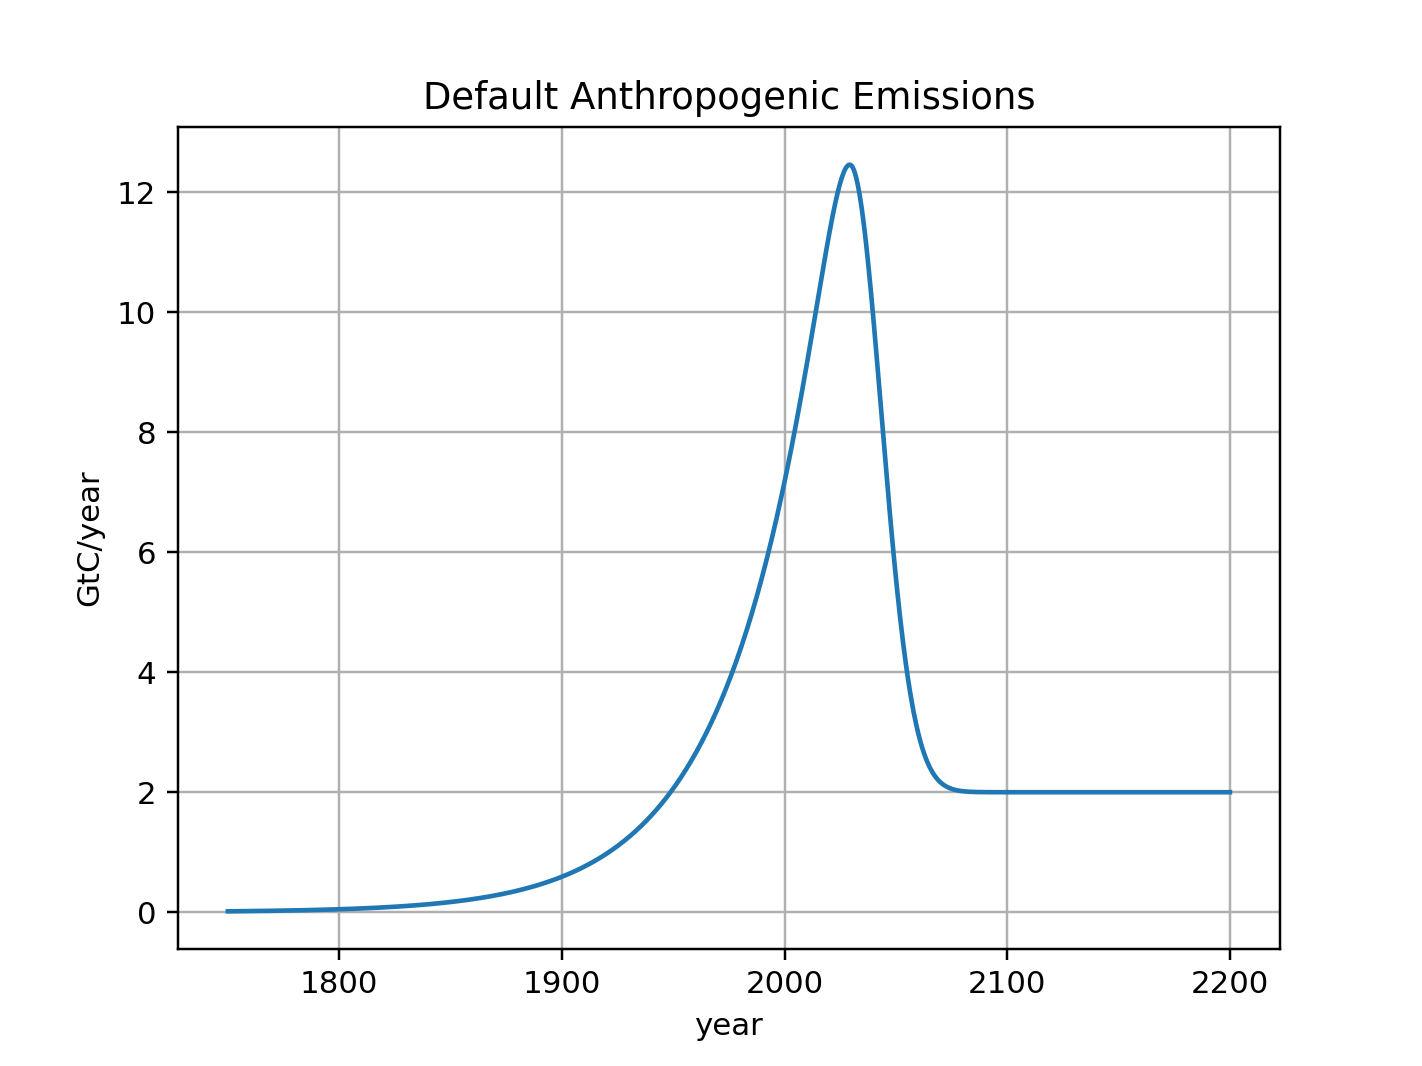

<IPython.core.display.Javascript object>


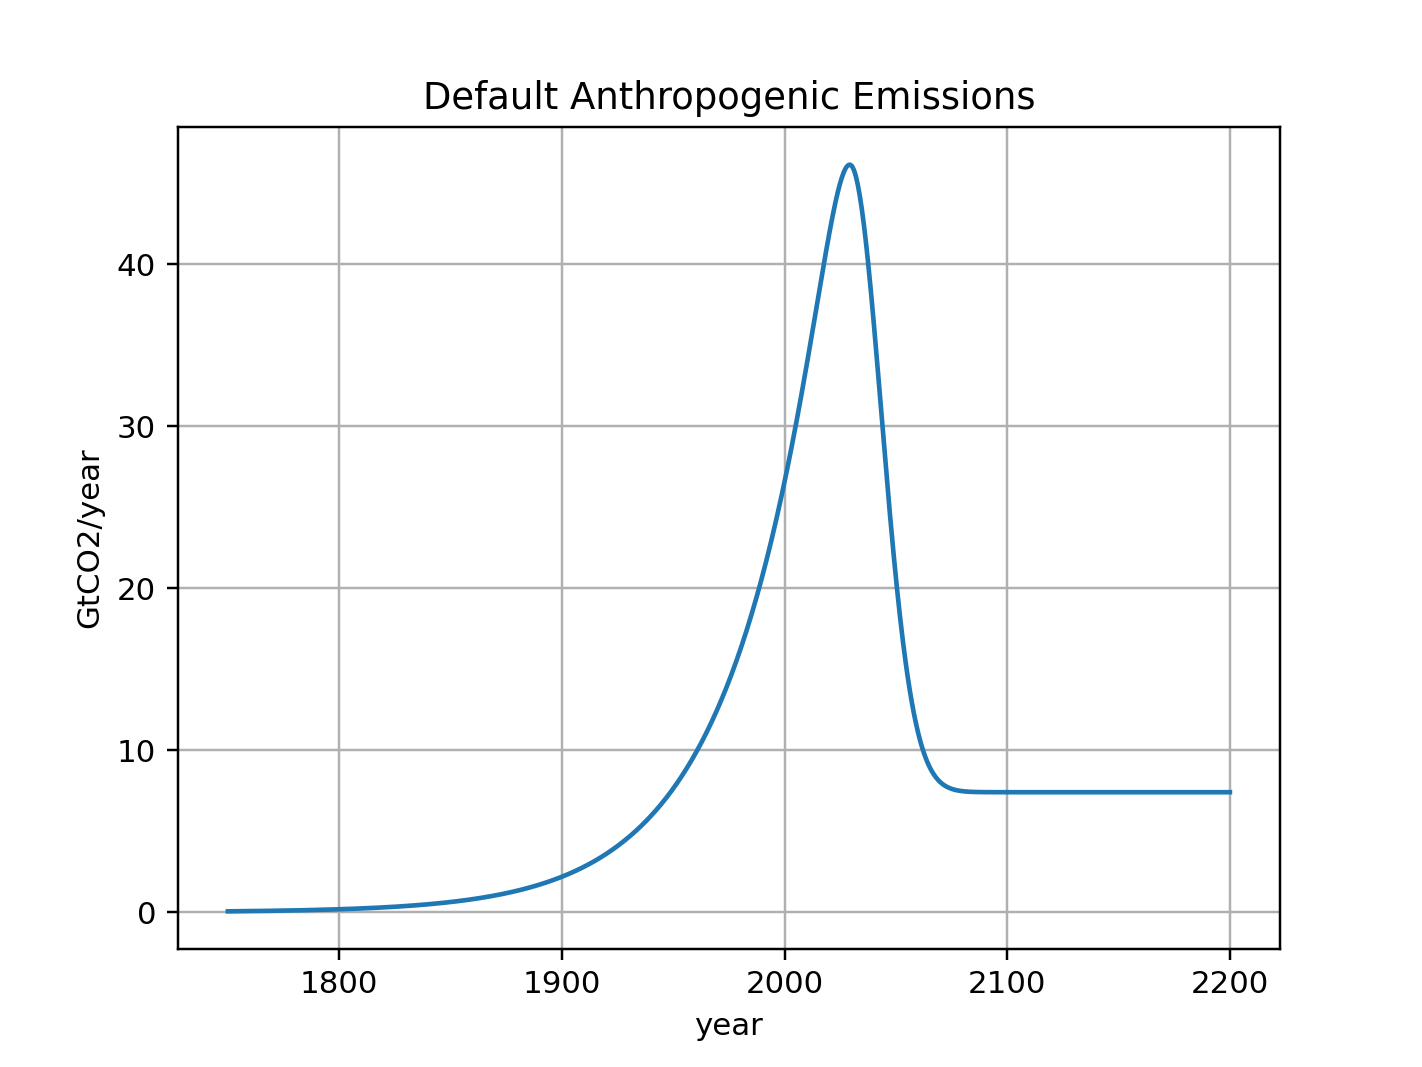

Text(0, 0.5, 'GtCO2/year')

In [5]:
# Your parameters for the LTE emissions maker
### BEGIN SOLUTION
SF_t_start = 1750
SF_t_stop = 2200
SF_nsteps = 1000
SF_k = 0.025
SF_t_trans = 2040
SF_delta_t_trans = 20
SF_t_0 = 2020
SF_eps_0 = 11.3
SF_LTE = 2
### END SOLUTION

# Call the LTE emissions scenario maker with these parameters
### BEGIN SOLUTION
time, eps = CL.MakeEmissionsScenarioLTE(\
    SF_t_start,SF_t_stop,SF_nsteps,SF_k,SF_eps_0,SF_t_0,SF_t_trans,SF_delta_t_trans,SF_LTE)
### END SOLUTION

# Plot it in units GtC/year
### BEGIN SOLUTION
plt.figure()
plt.plot(time,eps)
plt.grid(True)
plt.title('Anthropogenic Emissions w/LTE')
plt.xlabel('year')
plt.ylabel('GtC/year')
### END SOLUTION

# Also plot in GtCO2/year
### BEGIN SOLUTION
plt.figure()
plt.plot(time,eps/.27)
plt.grid(True)
plt.title('Anthropogenic Emissions w/LTE')
plt.xlabel('year')
plt.ylabel('GtCO2/year')
### END SOLUTION

### Creating a preindustrial Climate State
The cell below uses CreateClimateState to create a climate state called *PreindustClimateState*, containing preindustrial parameters. We've set the starting year to what was specified above when you created your scenario. Try it!

In [6]:
# Create a starting state -- the default is a preindustrial state
PreindustClimateState = CL.CreateClimateState(ClimateParams)

# Specify the starting year
PreindustClimateState['year'] = SF_t_start

# Display the state
display(PreindustClimateState)

{'C_atm': 615,
 'C_ocean': 350,
 'albedo': 0.3,
 'T_anomaly': 0,
 'pH': 0,
 'T_C': 0,
 'T_F': 0,
 'F_ha': 0,
 'F_ao': 0,
 'F_oa': 0,
 'F_al': 0,
 'F_la': 0,
 'year': 1750}

### Propagating through time
The cell below defines a function whose job is to propagate the climate state forward one time step. This is all done for you, but it's worth taking a few minutes to inspect the code so you understand how the feedbacks are activated, since eventually you'll be modifying this function to implement feedbacks you are interested in. 

In [7]:
def PropagateClimateState(previousClimateState, ClimateParams, dtime=1, F_ha=0):
    """Propagates the state of the climate, with a specified anthropogenic carbon flux"""
    """Default anthropogenic carbon flux is zero"""
    """Default time step is 1 year"""
    """Returns a new climate state"""

    # Extract concentrations from the previous climate state
    C_atm = previousClimateState['C_atm']
    C_ocean = previousClimateState['C_ocean']

    # Get the temperature anomaly resulting from carbon concentrations
    T_anomaly = CL.Diagnose_T_anomaly(C_atm, ClimateParams)
    
    # Get fluxes (optionally activating the impact temperature has on them)
    I_want_T_anomaly_feedback = False
    if I_want_T_anomaly_feedback:
        F_oa = CL.Diagnose_F_oa(C_ocean, T_anomaly, ClimateParams)
        F_al = CL.Diagnose_F_al(T_anomaly, C_atm, ClimateParams) 
    else:
        F_oa = CL.Diagnose_F_oa(C_ocean, 0, ClimateParams) 
        F_al = CL.Diagnose_F_al(0, C_atm, ClimateParams) 

    # Get other fluxes resulting from carbon concentrations
    F_ao = CL.Diagnose_F_ao(C_atm, ClimateParams)
    F_la = CL.Diagnose_F_la(ClimateParams)
    
    # Update concentrations of carbon based on these fluxes
    C_atm += (F_la + F_oa - F_ao - F_al + F_ha)*dtime
    C_ocean += (F_ao - F_oa)*dtime
    
    # Get albedo from temperature anomaly (optionally activating a constraint in case it's changing too fast)
    I_want_albedo_with_no_constraint = False
    if I_want_albedo_with_no_constraint:
        albedo = CL.Diagnose_albedo_with_constraint(T_anomaly, ClimateParams, previousClimateState['albedo'], dtime)
    else:
        albedo = CL.Diagnose_albedo(T_anomaly, ClimateParams)

    # Get a new temperature anomaly as impacted by albedo (if we want it)
    I_want_albedo_feedback = False
    if I_want_albedo_feedback:
        T_anomaly += CL.Diagnose_Delta_T_from_albedo(albedo,ClimateParams)
    
    # Stochasticity in the model (if we want it)
    I_want_stochastic_C_atm = False
    if I_want_stochastic_C_atm:
        C_atm = CL.Diagnose_Stochastic_C_atm(C_atm,ClimateParams)
    
    # Ordinary diagnostics
    pH  = CL.Diagnose_OceanSurfacepH(C_atm, ClimateParams)
    T_C = CL.Diagnose_actual_temperature(T_anomaly)
    T_F = CL.Diagnose_degreesF(T_C)

    # Create a new climate state with these updates
    ClimateState = makeacopy(previousClimateState)
    ClimateState['C_atm'] = C_atm
    ClimateState['C_ocean'] = C_ocean
    ClimateState['F_oa'] = F_oa
    ClimateState['F_ao'] = F_ao
    ClimateState['F_la'] = F_la
    ClimateState['F_al'] = F_al
    ClimateState['year'] += dtime
    ClimateState['F_ha'] = F_ha
    ClimateState['T_anomaly'] = T_anomaly
    ClimateState['pH'] = pH
    ClimateState['T_C'] = T_C
    ClimateState['T_F'] = T_F
    ClimateState['albedo'] = albedo

    # Return the new climate state
    return ClimateState

### Running the model
This is all done for you, but it's worth taking a few minutes to inspect the code so you understand what it's doing. 

In [8]:
# Initialize our list of climate states
ClimateState_list = []

# Make the starting state the preindustrial
ClimateState = CL.CreateClimateState(ClimateParams)

# Add some times
ClimateState['year'] = time[0] # This sets the starting year the same as the scheduled flow 
dt = time[1]-time[0]

# Loop over all the times in the scheduled flow
for i in range(len(time)):

    # Propagate
    ClimateState = PropagateClimateState(ClimateState,ClimateParams,dtime=dt,F_ha=eps[i])
    
    # Add to our list of climate states
    ClimateState_list.append(ClimateState)


### Visualizing the results of the run
Below, we use CL.CollectClimateTimeSeries to collect the time array from our results. We also collect the albedo, and do some fancy cosmetics, like making the lines a little thicker than the default, and specifying the vertical scale so that it displays the entire possible range of albedos a little better. 

<IPython.core.display.Javascript object>


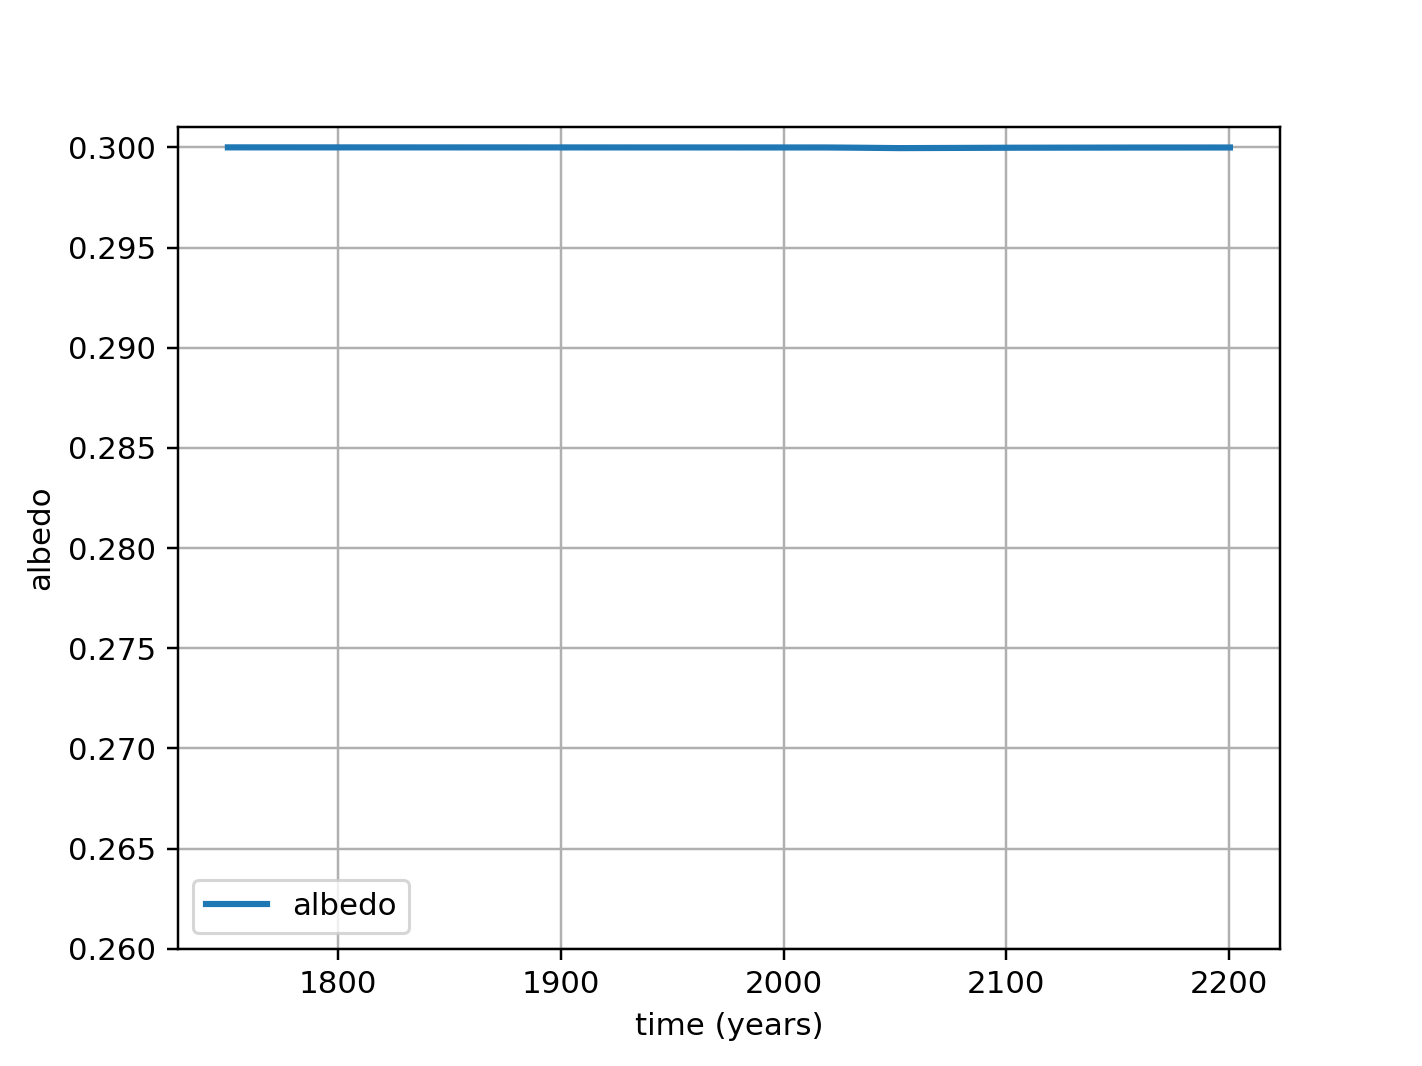

(0.2599998341072857, 0.3009998156747619)

In [9]:
# Here we are extracting the times from ClimateState_list
time = CL.CollectClimateTimeSeries(ClimateState_list,'year')

# Extract and plot the albedo 
albedo_array = CL.CollectClimateTimeSeries(ClimateState_list,'albedo')
plt.figure()
plt.plot(time,albedo_array,label='albedo',linewidth=2)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("albedo")
plt.legend()
ybottom = albedo_array[0]*ClimateParams['fractional_albedo_floor'] -0.01
ytop = albedo_array[0] +0.001
plt.ylim([ybottom, ytop])

### Your turn
Do some similar reporting to what you just did, but for other variables, as prompted. You can, of course, add other plots!

<IPython.core.display.Javascript object>


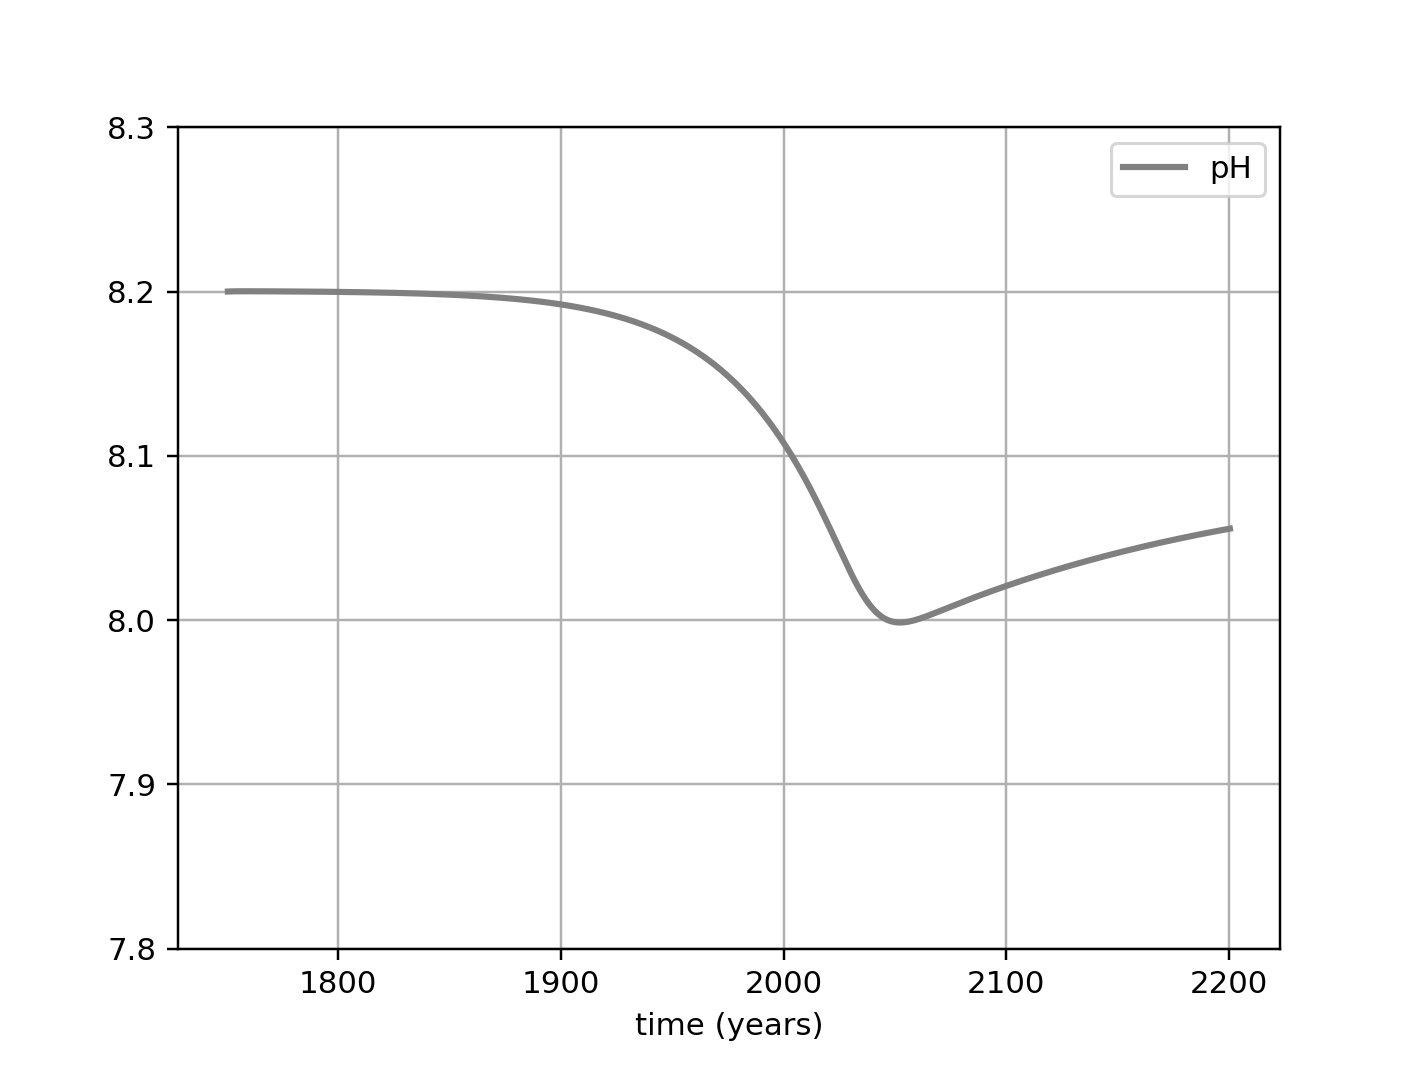

(7.8, 8.3)

In [10]:
# Extract and plot the ocean pH, specifying vertical axis limits of 7.8 to 8.3
### BEGIN SOLUTION
T_array = CL.CollectClimateTimeSeries(ClimateState_list,'pH')
plt.figure()
linewidth = 2
plt.plot(time,T_array,label='pH',linewidth=linewidth,color='gray')
plt.grid(True)
plt.xlabel('time (years)')
plt.legend()
ybottom = 7.8
ytop = 8.3
plt.ylim([ybottom, ytop])
### END SOLUTION

<IPython.core.display.Javascript object>


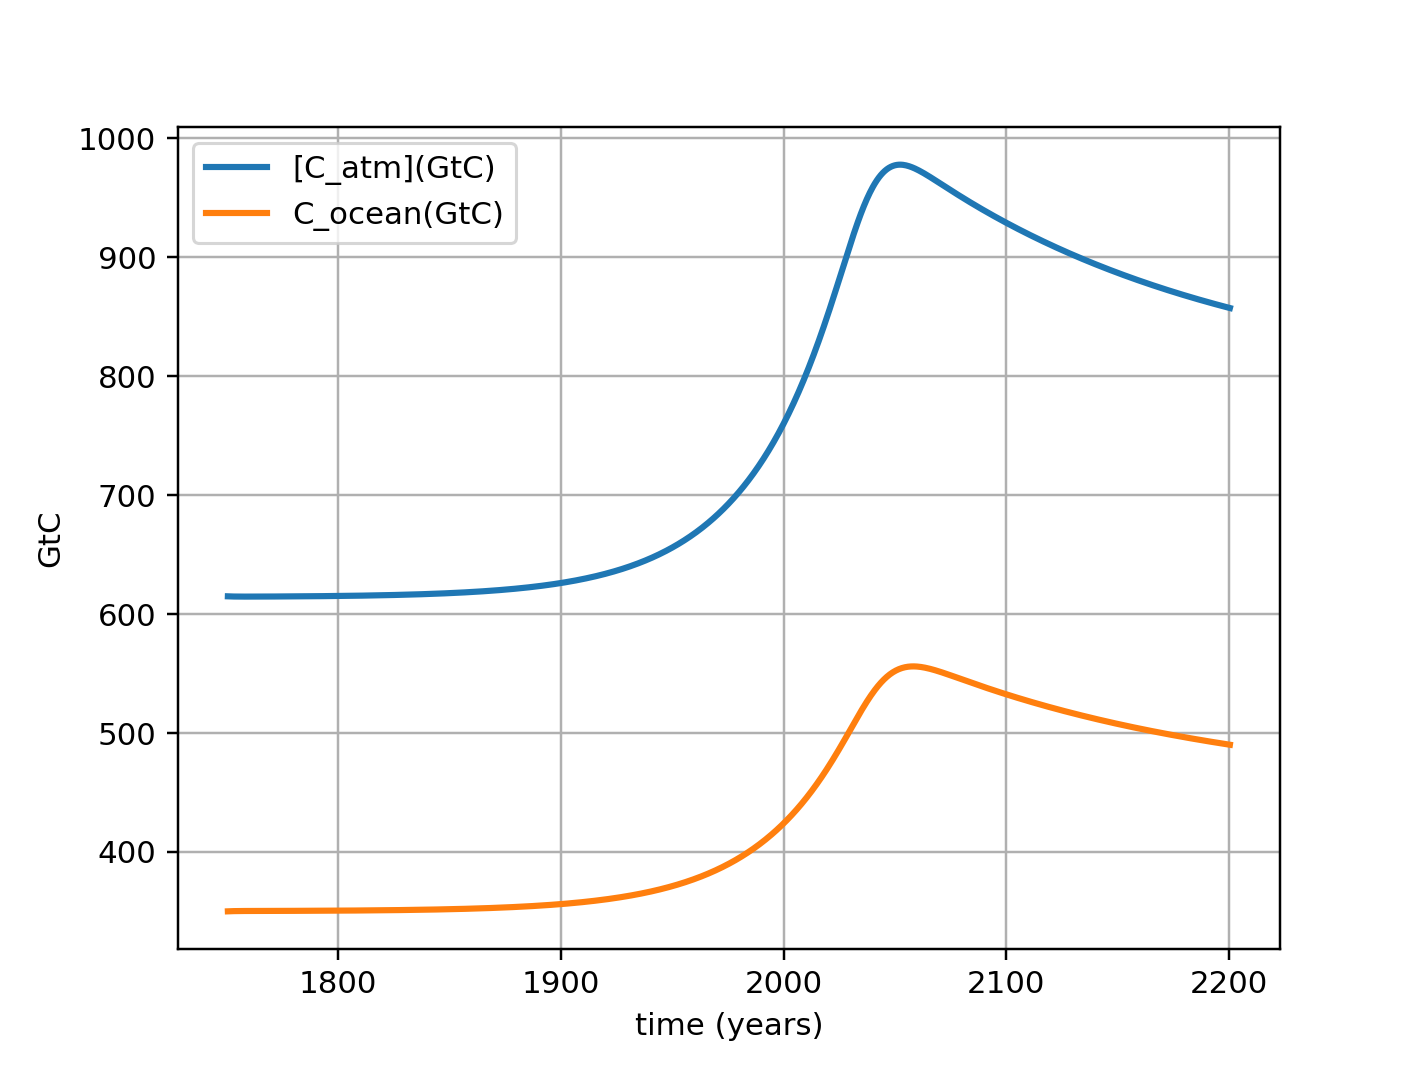

<IPython.core.display.Javascript object>


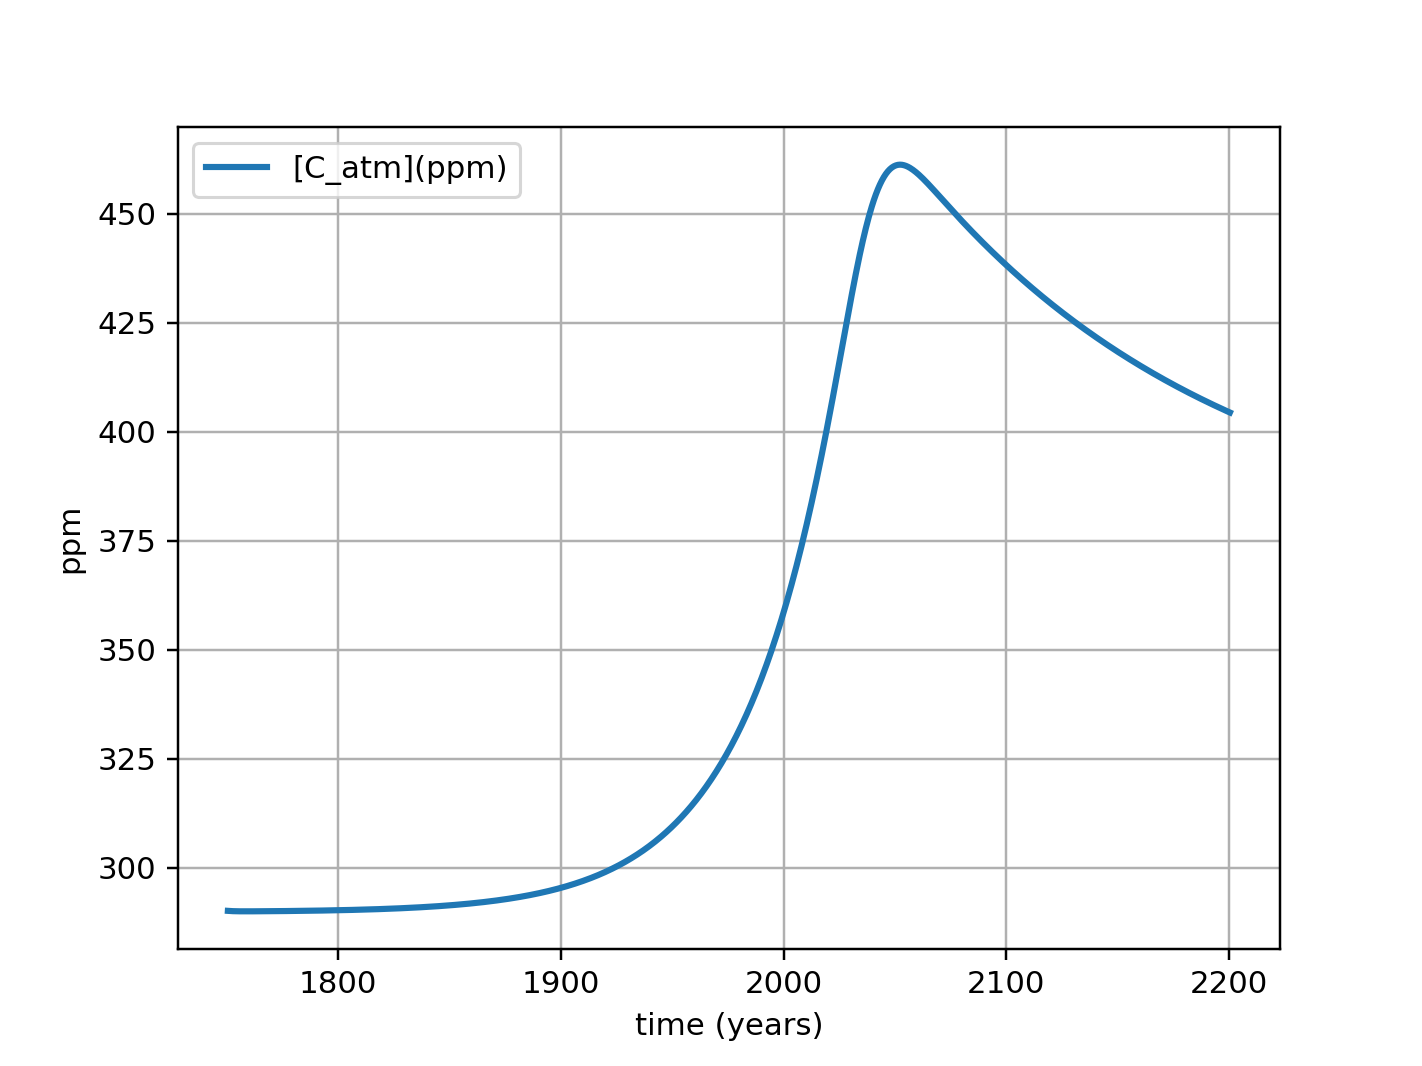

In [11]:
# Extract and plot the concentration of carbon in the atmosphere and oceans, in GtC (one graph)
### BEGIN SOLUTION
C_atm_array = CL.CollectClimateTimeSeries(ClimateState_list,'C_atm')
C_ocean_array = CL.CollectClimateTimeSeries(ClimateState_list,'C_ocean')
plt.figure()
plt.plot(time,C_atm_array,label='[C_atm](GtC)',linewidth=linewidth)
plt.plot(time,C_ocean_array,label='C_ocean(GtC)',linewidth=linewidth)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("GtC")
plt.legend()
### END SOLUTION

# Re-plot the carbon in the atmosphere, converted to ppm (by dividing C_atm_array by 2.12)
### BEGIN SOLUTION
plt.figure()
plt.plot(time,C_atm_array/2.12,label='[C_atm](ppm)',linewidth=linewidth)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("ppm")
plt.legend()
### END SOLUTION

<IPython.core.display.Javascript object>


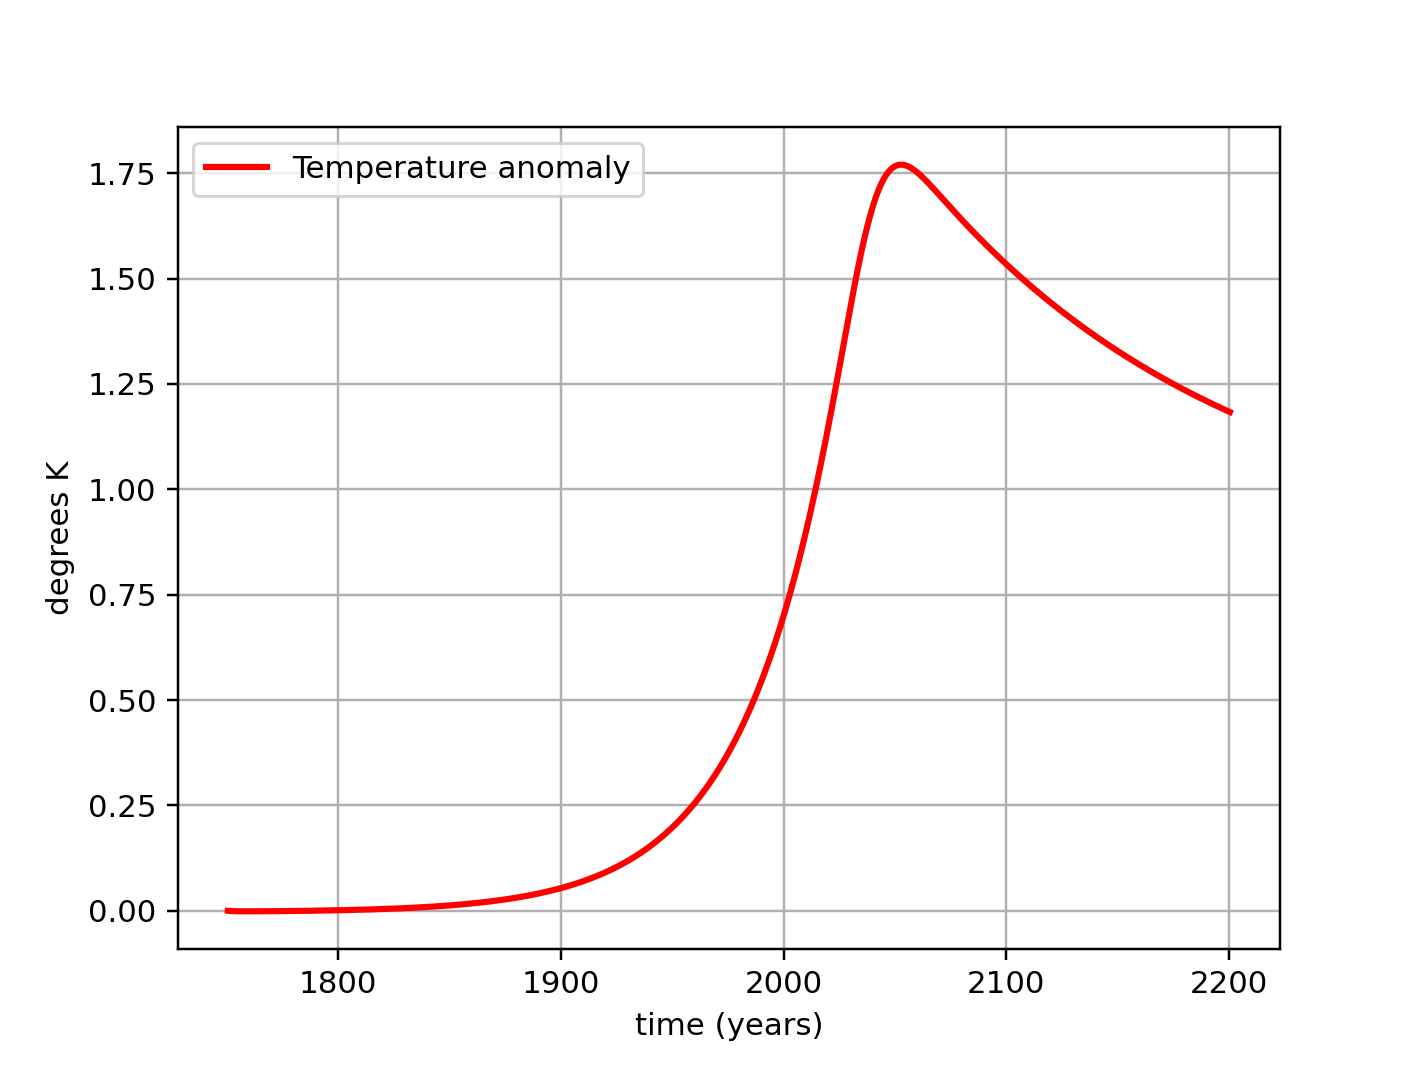

In [12]:
# Extract and plot the temperature anomaly
### BEGIN SOLUTION
T_array = CL.CollectClimateTimeSeries(ClimateState_list,'T_anomaly')
plt.figure()
plt.plot(time,T_array,label='Temperature anomaly',linewidth=linewidth,color='red')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("degrees K")
plt.legend()
### END SOLUTION

<IPython.core.display.Javascript object>


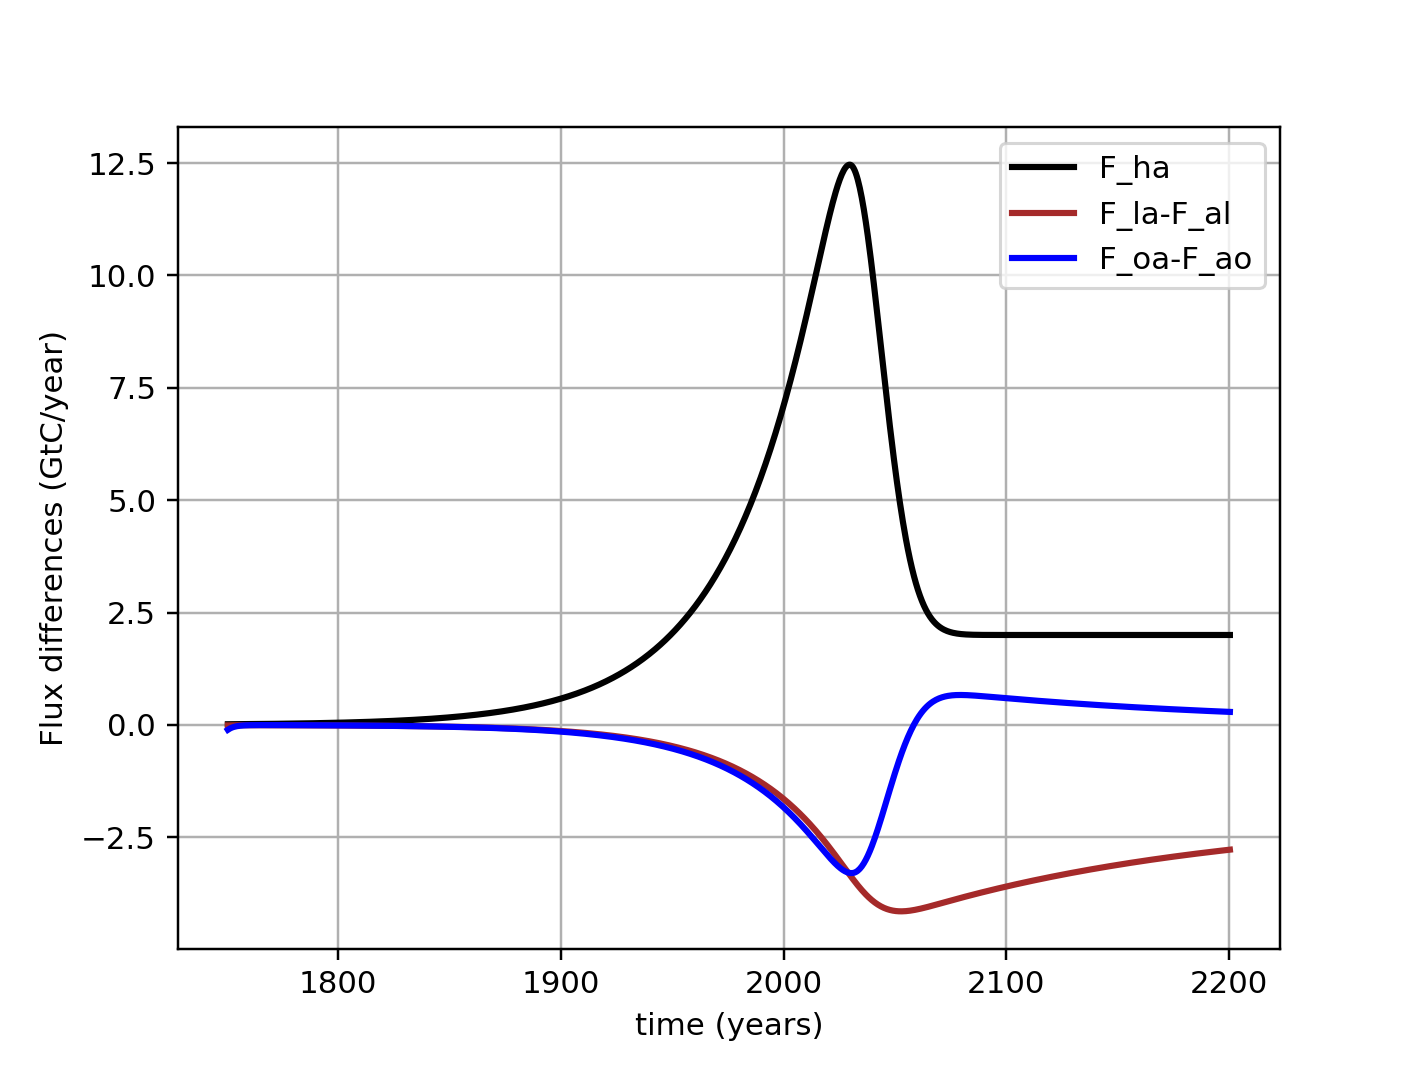

In [13]:
# Extract the fluxes, compute net fluxes, and plot them
### BEGIN SOLUTION
F_al_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_al')
F_la_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_la')
F_ao_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_ao')
F_oa_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_oa')
F_ha_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_ha')
plt.figure()
# fontsize=12
# plt.rcParams.update({'font.size': fontsize})
plt.plot(time,F_ha_array,label='F_ha',color='black',linewidth=linewidth)
plt.plot(time,-F_al_array+F_la_array,label='F_la-F_al',color='brown',linewidth=linewidth)
plt.plot(time,-F_ao_array+F_oa_array,label='F_oa-F_ao',color='blue',linewidth=linewidth)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("Flux differences (GtC/year)")
plt.legend()
### END SOLUTION

### Refresh/save/validate
Double-check everything is OK, and press the "Validate" button (as usual).

### Close/submit/logout
Close, submit, and log out.